In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [5]:
LOCATION = "data"
LOCATION_PROCESSED = 'data_processed'
SUBREDDITS = ['frugal', "anticonsumption", "BuyItForLife"]
ADVICE_SEEKING_SUBMISSIONS = f"{LOCATION_PROCESSED}/all_submissions_filtered_and_labelled_shopaholic.jsonl"
MIN_NUMBER_OF_WORDS = 5
# ADVICE_SEEKING_SUBMISSIONS = f"{LOCATION_PROCESSED}/r_frugal_posts.jsonl"

In [6]:
# load advice seeking submissions
df_advice_seeking_subs = pd.read_json(ADVICE_SEEKING_SUBMISSIONS, lines=True)

# filter out submissions that are not advice seeking
df_advice_seeking_subs = df_advice_seeking_subs[df_advice_seeking_subs['is_advice_seeking'] == True]
print(f"Number of advice seeking submissions: {len(df_advice_seeking_subs)}")

df_advice_seeking_shopaholic_subs = df_advice_seeking_subs[df_advice_seeking_subs['is_shopaholic'] == True]
print(f"Number of advice seeking shopaholic submissions: {len(df_advice_seeking_shopaholic_subs)}")

# create a set of unique submission ids
submission_ids = set(df_advice_seeking_shopaholic_subs['id'])
print(f"Number of unique submissions: {len(submission_ids)}")
print("example submission ids:")
print(list(submission_ids)[:5])

Number of advice seeking submissions: 130268
Number of advice seeking shopaholic submissions: 4997
Number of unique advice seeking submissions: 4997
example submission ids:
['xz6wqz', 'ul0rr0', '1q1ii0', '1sqxt1', '26nibl']


In [7]:
all_lines = []
# load jsonl data one line at a time
for subreddit in SUBREDDITS:
    subreddit_filename = f"{LOCATION}/r_{subreddit}_comments.jsonl"
    # count number of lines in file readlines
    print(f"Counting number of lines in {subreddit}")
    with open(subreddit_filename, 'r') as lines:
        n = len(lines.readlines())
    print(f"Number of lines in {subreddit}: {n}")

    print(f"Reading {n} lines from {subreddit}")
    with open(subreddit_filename, 'r') as f:
        for line in tqdm(f, total=n):
            data = json.loads(line)

            # keep only comments with score > 0
            score = data['score']
            if score < 0:
                continue

            link_id = data['link_id']
            parent_id = data['parent_id']

            # keep top level comments
            if parent_id != link_id:
                continue
            
            submission_id = link_id.split('_')[1]

            if(not submission_id in submission_ids):
                continue
            
            body = data['body']
            # number of words in comment
            num_words = len(body.split())
            if num_words < MIN_NUMBER_OF_WORDS:
                continue
            
            # if data['body'] == '[deleted]':
            #     continue

            # if data['body'] == '[removed]':
            #     continue

            all_lines.append(data)

Counting number of lines in frugal
Number of lines in frugal: 6344410
Reading 6344410 lines from frugal


100%|██████████| 6344410/6344410 [00:48<00:00, 131916.54it/s]


Counting number of lines in anticonsumption
Number of lines in anticonsumption: 1421585
Reading 1421585 lines from anticonsumption


100%|██████████| 1421585/1421585 [00:14<00:00, 98039.85it/s]


Counting number of lines in BuyItForLife
Number of lines in BuyItForLife: 2243333
Reading 2243333 lines from BuyItForLife


100%|██████████| 2243333/2243333 [00:19<00:00, 116882.44it/s]


In [8]:
scores = [x['score'] for x in all_lines]
print(f"Number of comments: {len(all_lines)}")
average_score = np.mean(scores)
print(f"Average score: {average_score}")

variance_score = np.var(scores)
print(f"Variance score: {variance_score}")

std_score = np.std(scores)
print(f"Standard deviation score: {std_score}")

# scores equal to 0
zero_scores = len([x for x in scores if x == 0])
print(f"Number of scores equal to 0: {zero_scores}")

# median score
median_score = int(np.median(scores))
print(f"Median score: {median_score}")

lines_above_median = [x for x in all_lines if x['score'] >= median_score]
print(f"Number of comments with a median score or higher: {len(lines_above_median)}")

Number of comments: 86804
Average score: 8.455820008294548
Variance score: 3341.582456680934
Standard deviation score: 57.8064222788518
Number of scores equal to 0: 1928
Median score: 2
Number of comments with a median score or higher: 50203


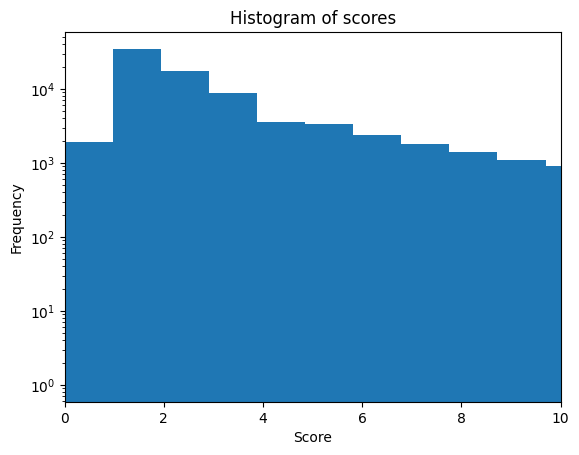

In [9]:
# plot histogram of scores
plt.hist(scores, bins=8000)
# make y axis logarithmic
plt.yscale('log')

# zoom in on x axis
plt.xlim(0, 10)
plt.title('Histogram of scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [10]:
# save the comments to a jsonl file
with open(f"{LOCATION_PROCESSED}/all_comments_used.jsonl", 'w') as f:
    for line in lines_above_median:
        f.write(json.dumps(line) + '\n')